# Exploratory Data Analysis (EDA)

In this notebook, we merge the weather datasets to the respective train and test sets. Subsequently, perform exploratory data analysis on the train set. 

Contents:
- [Imports](#Import-libraries-and-data)
- [Exclude spray data](#Exclude-spray-data)
- [Nearest station based on coordinates of trap location](#Nearest-station-based-on-coordinates-of-trap-location)
- [Merge weather dataset on train and test set](#Merge-weather-datasaet-on-train-and-test-set)
- [Formatting for model prep](#Formatting-for-model-prep)
- [One hot encode categorical variables](#One-hot-encode-categorical-variables)
- [Target variable - wnvpresent](#Target-variable)
- [Add grid number](#Add-grid-number)
- [View correlation](#Correlation)

### Import libraries and data

In [365]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from prettytable import PrettyTable
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('whitegrid')

from geopy import distance
from geopy.distance import geodesic
from sklearn.feature_selection import chi2, SelectKBest

In [366]:
# read clean files
train = pd.read_csv("../data/clean/train_clean.csv")
test = pd.read_csv("../data/clean/test_clean.csv")
weather = pd.read_csv("../data/clean/weather_clean.csv")
spray = pd.read_csv("../data/clean/spray_clean.csv")

### Exclude spray data
We noted that spraying efforts were only done on 10 days, which may not result in useful analysis, so we will not consider spray data any further from here. 

In [367]:
spray.groupby('Date')['Date'].count()

Date
2011-08-29      95
2011-09-07    2114
2013-07-17    2202
2013-07-25    1607
2013-08-08    1195
2013-08-15    2668
2013-08-16     141
2013-08-22    1587
2013-08-29    2302
2013-09-05     924
Name: Date, dtype: int64

We proceed to merge weather data onto train and test sets respectively. All changes made to merged train set must also reflect in train set. 

### Nearest station based on coordinates of trap location
As the weather data comprise both station 1 and station 2 data, we will only take the data from station nearest to the trap location. On the train and test set, we find the nearest staion first, and subsquently, merged the weather data. 

In [368]:
# coordinates of station 1 and 2
stn1 = (41.995, -87.933)
stn2 = (41.786, -87.752) 

def nearest_stn(lat, lon):
    '''function that assigns the nearest station based on trap site'''
    dist_stn_1 = geodesic(stn1,(lat,lon)).km
    dist_stn_2 = geodesic(stn2,(lat,lon)).km
    if dist_stn_1 <= dist_stn_2:
        return 1
    else:
        return 2

In [369]:
%%time
# assign nearest station for each entry in train and test set. 
for index,row in train.iterrows():
    nearest_station = nearest_stn(row['latitude'], row['longitude'])
    train.loc[index, 'nearest_stn'] = nearest_station

Wall time: 4.81 s


In [370]:
%%time
for index,row in test.iterrows():
    nearest_station = nearest_stn(row['latitude'], row['longitude'])
    test.loc[index, 'nearest_stn'] = nearest_station

Wall time: 1min 15s


In [371]:
# check updates
display(train.head())
print("Shape of train set: ", train.shape)
display(test.head())
print("Shape of test set: ", test.shape)
# view weather df
display(weather.head())
print("Shape of weather set: ", weather.shape)

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,wnvpresencefreq,nearest_stn
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,0.0,1.0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,0.0,1.0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,0.0,1.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,0.0,1.0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,0.0,1.0


Shape of train set:  (8475, 9)


,id,date,species,trap,latitude,longitude,wnvpresencefreq,nummosquitos,nearest_stn
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,0.000222,14.0,1.0
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,0.000222,14.0,1.0
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,0.000222,14.0,1.0
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,0.000222,14.0,1.0
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,0.000222,14.0,1.0


Shape of test set:  (116293, 9)


,station,date,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,resultspeed,...,depart_10,dewpoint_10,wetbulb_10,heat_10,cool_10,preciptotal_10,resultspeed_10,avgspeed_10,humidity_10,darkhours_10
0,1,2007-05-01,67.0,14.0,51,56.0,0.0,2.0,0.0,1.7,...,14.0,51.0,56.0,0.0,2.0,0.0,1.7,9.2,55.555556,9.99
1,2,2007-05-01,68.0,14.5,51,57.0,0.0,3.0,0.0,2.7,...,14.5,51.0,57.0,0.0,3.0,0.0,2.7,9.6,52.777778,9.99
2,1,2007-05-02,51.0,-3.0,42,47.0,14.0,0.0,0.0,13.0,...,-3.0,42.0,47.0,14.0,0.0,0.0,13.0,13.4,75.000000,9.97
3,2,2007-05-02,52.0,-1.5,42,47.0,13.0,0.0,0.0,13.3,...,-1.5,42.0,47.0,13.0,0.0,0.0,13.3,13.4,72.222222,9.97
4,1,2007-05-03,56.0,2.0,40,48.0,9.0,0.0,0.0,11.7,...,2.0,40.0,48.0,9.0,0.0,0.0,11.7,11.9,55.555556,9.95


Shape of weather set:  (2944, 38)


### Merge weather dataset on train and test set

In [372]:
# split dataframes by station
train_stn_1 = train[train['nearest_stn'] == 1]
train_stn_2 = train[train['nearest_stn'] == 2]
test_stn_1 = test[test['nearest_stn'] == 1]
test_stn_2 = test[test['nearest_stn'] == 2]

# split weather stn into 1 and 2
weather_stn_1 = weather[weather['station'] == 1]
weather_stn_2 = weather[weather['station'] == 2]

In [373]:
# merge weather data
train_1_merged = pd.merge(train_stn_1, weather_stn_1, on = 'date', how = 'left')
train_2_merged = pd.merge(train_stn_2, weather_stn_2, on = 'date', how = 'left')
test_1_merged = pd.merge(test_stn_1, weather_stn_1, on = 'date', how = 'left')
test_2_merged = pd.merge(test_stn_2, weather_stn_2, on = 'date', how = 'left')

In [374]:
# recombine train and test sets
merged_train = pd.concat([train_1_merged, train_2_merged], ignore_index = True, sort = True)
merged_test = pd.concat([test_1_merged, test_2_merged], ignore_index = True, sort = True)

In [375]:
# check updates
display(merged_train.head())
print("Shape of merged train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of merged test set: ", merged_test.shape)

,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,tavg_10,tavg_7,trap,weekofyear,wetbulb,wetbulb_10,wetbulb_7,wnvpresencefreq,wnvpresent,year
0,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,65.6,64.857143,T002,22,65.0,57.3,57.714286,0.0,0,2007
1,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,65.6,64.857143,T002,22,65.0,57.3,57.714286,0.0,0,2007
2,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,65.6,64.857143,T007,22,65.0,57.3,57.714286,0.0,0,2007
3,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,65.6,64.857143,T015,22,65.0,57.3,57.714286,0.0,0,2007
4,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,65.6,64.857143,T015,22,65.0,57.3,57.714286,0.0,0,2007


Shape of merged train set:  (8475, 46)


,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,tavg,tavg_10,tavg_7,trap,weekofyear,wetbulb,wetbulb_10,wetbulb_7,wnvpresencefreq,year
0,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.857143,0.000222,2008
1,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.857143,0.000222,2008
2,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.857143,0.000222,2008
3,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.857143,0.000222,2008
4,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.857143,0.000222,2008


Shape of merged test set:  (116293, 46)


### Formatting for model prep

We round the figures into 4 decimal places for easier handling. 

In [376]:
# round the fields to 4 decimal places
print("Merged train set")
display(merged_train.round(decimals = 4).head())
print("Merged test set")
display(merged_test.round(decimals = 4).head())

Merged train set


,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,tavg_10,tavg_7,trap,weekofyear,wetbulb,wetbulb_10,wetbulb_7,wnvpresencefreq,wnvpresent,year
0,6.5,8.29,7.2429,9.0,2.4,1.7143,9.04,9.069,9.0571,2007-05-29,...,65.6,64.8571,T002,22,65.0,57.3,57.7143,0.0,0,2007
1,6.5,8.29,7.2429,9.0,2.4,1.7143,9.04,9.069,9.0571,2007-05-29,...,65.6,64.8571,T002,22,65.0,57.3,57.7143,0.0,0,2007
2,6.5,8.29,7.2429,9.0,2.4,1.7143,9.04,9.069,9.0571,2007-05-29,...,65.6,64.8571,T007,22,65.0,57.3,57.7143,0.0,0,2007
3,6.5,8.29,7.2429,9.0,2.4,1.7143,9.04,9.069,9.0571,2007-05-29,...,65.6,64.8571,T015,22,65.0,57.3,57.7143,0.0,0,2007
4,6.5,8.29,7.2429,9.0,2.4,1.7143,9.04,9.069,9.0571,2007-05-29,...,65.6,64.8571,T015,22,65.0,57.3,57.7143,0.0,0,2007


Merged test set


,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,tavg,tavg_10,tavg_7,trap,weekofyear,wetbulb,wetbulb_10,wetbulb_7,wnvpresencefreq,year
0,10.0,11.53,10.0286,9.0,8.9,7.0,8.9,8.916,8.9086,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.8571,0.0002,2008
1,10.0,11.53,10.0286,9.0,8.9,7.0,8.9,8.916,8.9086,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.8571,0.0002,2008
2,10.0,11.53,10.0286,9.0,8.9,7.0,8.9,8.916,8.9086,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.8571,0.0002,2008
3,10.0,11.53,10.0286,9.0,8.9,7.0,8.9,8.916,8.9086,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.8571,0.0002,2008
4,10.0,11.53,10.0286,9.0,8.9,7.0,8.9,8.916,8.9086,2008-06-11,...,74.0,73.9,72.0,T002,24,64.0,67.9,65.8571,0.0002,2008


### One hot encode categorical variables
Only the `species` feature is categorical, so we will one hot encode this. Drop `trap` as we have other features that relate to the trap location and have more interpretable value than `trap`.

In [377]:
# one hot encode species prior to modelling
merged_train = pd.get_dummies(merged_train, columns = ['species'], prefix = 'species')
merged_test = pd.get_dummies(merged_test, columns = ['species'], prefix = 'species')

In [378]:
# view shape
print("Shape of testing set: ", merged_test.shape)
print("Shape of training set: ", merged_train.shape)

Shape of testing set:  (116293, 53)
Shape of training set:  (8475, 52)


In [379]:
# find columns in test set but not in train set 
train_cols = merged_train.columns
test_cols = merged_test.columns
test_not_train = test_cols.difference(train_cols)
print(test_not_train)

Index(['id', 'species_UNSPECIFIED CULEX'], dtype='object')


In [380]:
# find columns in train set but not in test set
train_not_test = train_cols.difference(test_cols)
print(train_not_test)

Index(['wnvpresent'], dtype='object')


Once one hot encoded, we noted that one of the species, `species_UNSPECIFIED CULEX` and `traps` is only present in the test set and not the train set. We will drop these trap locations from the test set for consistency, as the model will not be able to handle a column with null values when train set is fed into the model. 

In [381]:
#create column
merged_train['species_UNSPECIFIED CULEX'] = 0

In [382]:
#make values zero
merged_train.fillna(0, inplace = True)

In [383]:
# drop trap column
merged_train.drop(columns = ['trap'], inplace = True)
merged_test.drop(columns = ['trap'], inplace = True)

In [384]:
# view shape
print("Shape of testing set: ", merged_test.shape)
print("Shape of training set: ", merged_train.shape)

Shape of testing set:  (116293, 52)
Shape of training set:  (8475, 52)


### Target variable

In [385]:
# count number of wnv presence in dataset 
merged_train.wnvpresent.value_counts(normalize = True)

0    0.946077
1    0.053923
Name: wnvpresent, dtype: float64

From here we see that there is a highly imbalanced class with 95% of the dataset showing no WNV presence, while only 5% showed WNV presence in the trap location. 

Due to this, we will note to apply oversampling techniques prior to modelling to balance these classes first.

### Add grid number
Add a grid number for each coordinates in train and test sets.

In [386]:
# function to assign a grid number to a particular coordinate based on the range of max/min coordinates

# inputs: long, lat of a particular coordinate
# stats: range of max/min long, lat of an area, in form of dictionary long_max, long_min, lat_max, lat_min
# default: 10x10 grid
# most south western grid is 0, most north eastern grid is 99

def calculate_grid(long, lat, stats):
    row_total = 10
    column_total = 10
    stats = stats
    long_range = stats["long_max"] - stats["long_min"]
    lat_range = stats["lat_max"] - stats["lat_min"]
    row_no = (lat - stats["lat_min"])//(lat_range/row_total)
    column_no = (long - stats["long_min"])//(long_range/column_total)
    grid_no = row_no * column_total + column_no
    
    # error - returns 999
    if ((abs(row_no) > 9) or (abs(column_no) > 9)):
        grid_no = 999
    
    return grid_no

In [387]:
%%time
# create a new column for grid_no for train set
grid_no = []
stats = {'long_max': -87.52598666666667,
 'long_min': -88.10211666666663,
 'lat_max': 42.40349704666663,
 'lat_min': 41.63709828666667}

for i in range(len(merged_train[["latitude"]])):
    long = merged_train.loc[i,"longitude"]
    lat = merged_train.loc[i,"latitude"]
    merged_train.loc[i,"grid_no"] = calculate_grid(long, lat, stats)

Wall time: 1.82 s


In [388]:
%%time
# create a new column for grid_no for test set
grid_no = []
stats = {'long_max': -87.52598666666667,
 'long_min': -88.10211666666663,
 'lat_max': 42.40349704666663,
 'lat_min': 41.63709828666667}

for i in range(len(merged_test[["latitude"]])):
    long = merged_test.loc[i,"longitude"]
    lat = merged_test.loc[i,"latitude"]
    merged_test.loc[i,"grid_no"] = calculate_grid(long, lat, stats)

Wall time: 35.3 s


In [389]:
# check updates
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,year,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no
0,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,2007,0,0,1,0,0,0,0,0,45.0
1,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,2007,0,0,0,1,0,0,0,0,45.0
2,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,2007,0,0,0,1,0,0,0,0,45.0
3,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,2007,0,0,1,0,0,0,0,0,44.0
4,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,2007,0,0,0,1,0,0,0,0,44.0


Shape of train set:  (8475, 53)


,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,year,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no
0,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,2008,0,0,1,0,0,0,0,0,45.0
1,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,2008,0,0,0,1,0,0,0,0,45.0
2,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,2008,0,1,0,0,0,0,0,0,45.0
3,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,2008,0,0,0,0,1,0,0,0,45.0
4,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,2008,0,0,0,0,0,0,1,0,45.0


Shape of test set:  (116293, 53)


### Spatial closeness to top 5 traps
Create features that represent how close the space is to the trap locations with the highest occurrence of WNV. The top 5 traps are on grid number 45, 36, 18, 27 and 37. 

In [390]:
def grid_distance_sq_inv(a,b):
    '''function gets the sq inverse of grid distance'''
    a_row = a//10
    a_col = a%10
    b_row = b//10
    b_col = b%10
    sq2 = ((a_row - b_row)**2 + (a_col - b_col)**2)
    if(sq2==0):
        sq2=1
    return 1/sq2

In [391]:
# create new features for areas close to top 5 locations with highest occurrence of WNV.
merged_train["close_to_45"] = [grid_distance_sq_inv(45,x) for x in merged_train["grid_no"]]
merged_train["close_to_36"] = [grid_distance_sq_inv(36,x) for x in merged_train["grid_no"]]
merged_train["close_to_18"] = [grid_distance_sq_inv(18,x) for x in merged_train["grid_no"]]
merged_train["close_to_27"] = [grid_distance_sq_inv(27,x) for x in merged_train["grid_no"]]
merged_train["close_to_37"] = [grid_distance_sq_inv(37,x) for x in merged_train["grid_no"]]
merged_train["close_to_top_traps"] = merged_train["close_to_45"] + merged_train["close_to_36"] + merged_train["close_to_18"] + merged_train["close_to_27"] + merged_train["close_to_37"]

In [392]:
merged_test["close_to_45"] = [grid_distance_sq_inv(45,x) for x in merged_test["grid_no"]]
merged_test["close_to_36"] = [grid_distance_sq_inv(36,x) for x in merged_test["grid_no"]]
merged_test["close_to_18"] = [grid_distance_sq_inv(18,x) for x in merged_test["grid_no"]]
merged_test["close_to_27"] = [grid_distance_sq_inv(27,x) for x in merged_test["grid_no"]]
merged_test["close_to_37"] = [grid_distance_sq_inv(37,x) for x in merged_test["grid_no"]]
merged_test["close_to_top_traps"] = merged_test["close_to_45"] + merged_test["close_to_36"] + merged_test["close_to_18"] + merged_test["close_to_27"] + merged_test["close_to_37"]

In [393]:
# check updates
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
1,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
2,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
3,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923
4,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923


Shape of train set:  (8475, 59)


,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
1,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
2,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
3,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
4,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,1,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556


Shape of test set:  (116293, 59)


### Correlation
We explore the correlation of each features with the target variable, wnvpresent.

In [394]:
# explore correlation with the target vriable
merged_train.corr()['wnvpresent'].sort_values()

species_CULEX RESTUANS           -0.094047
longitude                        -0.076732
station                          -0.066947
nearest_stn                      -0.066947
heat_10                          -0.066818
heat_7                           -0.063051
close_to_27                      -0.062154
heat                             -0.056166
close_to_top_traps               -0.055389
close_to_37                      -0.054410
resultspeed                      -0.051165
resultspeed_10                   -0.041960
avgspeed_10                      -0.041436
species_CULEX TERRITANS          -0.038609
resultspeed_7                    -0.036802
avgspeed                         -0.036245
close_to_18                      -0.036048
close_to_36                      -0.027465
species_CULEX SALINARIUS         -0.023743
avgspeed_7                       -0.021634
species_CULEX TARSALIS           -0.006355
species_CULEX ERRATICUS          -0.002593
depart                            0.001720
preciptotal

From here, we see that there isn't a very strong correlation between the features and the target variable other than WNV presence frequency.

Features with the strongest correlation are:
1. wnvpresencefrequency
2. number of mosquitoes
3. dewpoint rolling 7 days

### Check for multicollinearity

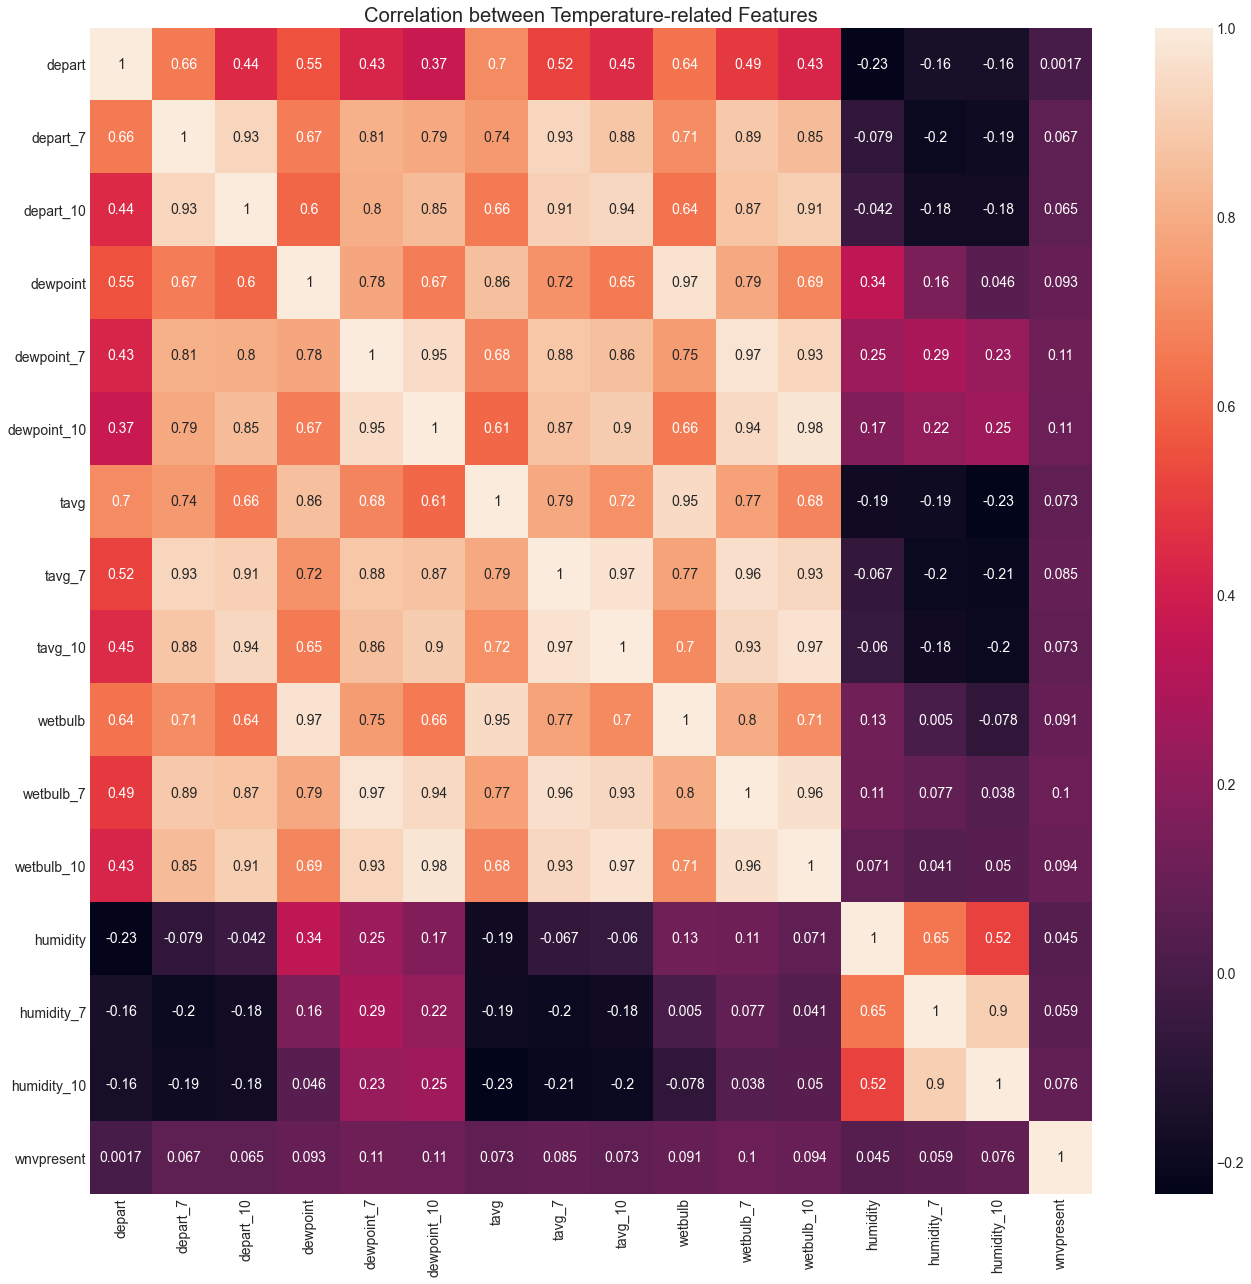

In [395]:
# check for multicollinearity for temperature related features
temp_features = ['depart', 'depart_7', 'depart_10','dewpoint','dewpoint_7','dewpoint_10','tavg','tavg_7','tavg_10','wetbulb','wetbulb_7','wetbulb_10', 'humidity', 'humidity_7', 'humidity_10','wnvpresent']
plt.figure(figsize = (20,20))
sns.heatmap(merged_train[temp_features].corr(), annot = True)
plt.title("Correlation between Temperature-related Features");

All the features have >0.5 correlation with each other, so we will drop all of these except for the one with the stronger correlation to `wnvpresent`. `dewpoint_10` has the strongest correlation with `wnvpresent`. Dewpoint has strong correlation with wetbulb and average temperature generally so we have to drop those. We will drop humidity also since it shows very little correlation with `wnvpresent`. `depart` has very little to no correlation with `wnvpresent` and it has very high correlation with `dewpoint_10` so we will drop this. 

In [396]:
merged_train.drop(columns = ['dewpoint', 'dewpoint_7', 'tavg', 'tavg_7', 'tavg_10', 'wetbulb', 'wetbulb_7', 'wetbulb_10', 'humidity', 'humidity_7', 'humidity_10', 'depart', 'depart_7','depart_10'], inplace = True)
merged_test.drop(columns = ['dewpoint', 'dewpoint_7', 'tavg', 'tavg_7', 'tavg_10', 'wetbulb', 'wetbulb_7', 'wetbulb_10', 'humidity', 'humidity_7', 'humidity_10', 'depart', 'depart_7','depart_10'], inplace = True)
#view
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
1,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
2,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
3,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923
4,6.5,8.29,7.242857,9.0,2.4,1.714286,9.04,9.069,9.057143,2007-05-29,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923


Shape of train set:  (8475, 45)


,avgspeed,avgspeed_10,avgspeed_7,cool,cool_10,cool_7,darkhours,darkhours_10,darkhours_7,date,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
1,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
2,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
3,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
4,10.0,11.53,10.028571,9.0,8.9,7.0,8.9,8.916,8.908571,2008-06-11,...,0,1,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556


Shape of test set:  (116293, 45)


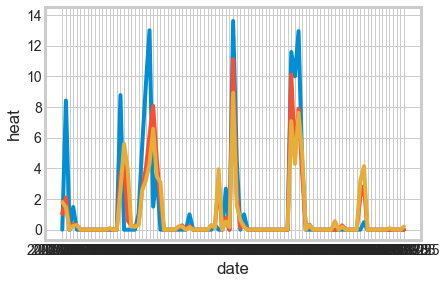

In [397]:
#lineplot for heat and cool
sns.lineplot(data = merged_train, y ='heat', x = 'date')
sns.lineplot(data = merged_train, y ='heat_7', x = 'date')
sns.lineplot(data = merged_train, y ='heat_10', x = 'date');

All three of them show a similar trend, thus, collinear with each other. So we will keep just one of this.

In [398]:
# explore correlation of each of heat and cool with target vriable
heat = merged_train[['heat', 'heat_7', 'heat_10', 'wnvpresent']]
heat.corr()['wnvpresent'].sort_values()

heat_10      -0.066818
heat_7       -0.063051
heat         -0.056166
wnvpresent    1.000000
Name: wnvpresent, dtype: float64

`heat_10` has the strongest correlation with `wnvpresent` so we will keep this, and drop others.

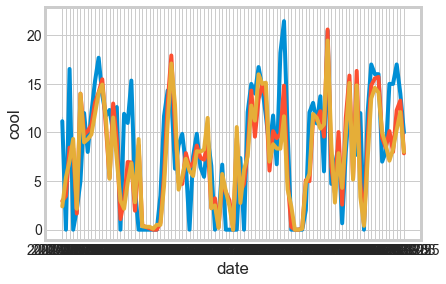

In [399]:
#lineplot for heat and cool
sns.lineplot(data = merged_train, y ='cool', x = 'date')
sns.lineplot(data = merged_train, y ='cool_7', x = 'date')
sns.lineplot(data = merged_train, y ='cool_10', x = 'date');

In [400]:
# explore correlation of each of heat and cool with target vriable
cool = merged_train[['cool', 'cool_7', 'cool_10', 'wnvpresent']]
cool.corr()['wnvpresent'].sort_values()

cool_10       0.067795
cool          0.069386
cool_7        0.084655
wnvpresent    1.000000
Name: wnvpresent, dtype: float64

`cool_7` has the strongest correlation with `wnvpresent` so we will keep this, and drop others.

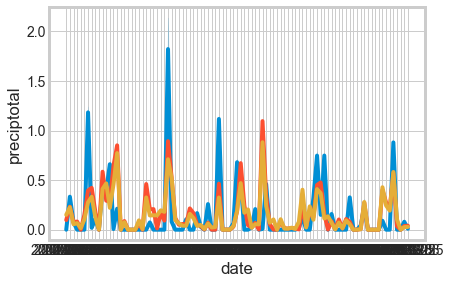

In [401]:
#lineplot for heat and cool
sns.lineplot(data = merged_train, y ='preciptotal', x = 'date')
sns.lineplot(data = merged_train, y ='preciptotal_7', x = 'date')
sns.lineplot(data = merged_train, y ='preciptotal_10', x = 'date');

In [402]:
# explore correlation of each of heat and cool with target vriable
precip = merged_train[['preciptotal', 'preciptotal_7', 'preciptotal_10', 'wnvpresent']]
precip.corr()['wnvpresent'].sort_values()

preciptotal       0.013969
preciptotal_7     0.033094
preciptotal_10    0.033842
wnvpresent        1.000000
Name: wnvpresent, dtype: float64

These are strongly correlated. We will keep `preciptotal_10` and drop the rest. 

In [403]:
# drop columns
merged_train.drop(columns = ['heat', 'heat_7', 'cool', 'cool_10', 'preciptotal', 'preciptotal_7'], inplace = True)
merged_test.drop(columns = ['heat', 'heat_7', 'cool', 'cool_10','preciptotal', 'preciptotal_7'], inplace = True)
# view
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed,avgspeed_10,avgspeed_7,cool_7,darkhours,darkhours_10,darkhours_7,date,dewpoint_10,heat_10,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,6.5,8.29,7.242857,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
1,6.5,8.29,7.242857,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
2,6.5,8.29,7.242857,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
3,6.5,8.29,7.242857,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923
4,6.5,8.29,7.242857,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923


Shape of train set:  (8475, 39)


,avgspeed,avgspeed_10,avgspeed_7,cool_7,darkhours,darkhours_10,darkhours_7,date,dewpoint_10,heat_10,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,10.0,11.53,10.028571,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
1,10.0,11.53,10.028571,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
2,10.0,11.53,10.028571,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
3,10.0,11.53,10.028571,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
4,10.0,11.53,10.028571,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,...,0,1,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556


Shape of test set:  (116293, 39)


In [404]:
# explore correlation of each of wind speed with target vriable
wind = merged_train[['resultspeed', 'resultspeed_7', 'resultspeed_10', 'avgspeed_10', 'avgspeed_7', 'avgspeed', 'wnvpresent']]
wind.corr()['wnvpresent'].sort_values()

resultspeed      -0.051165
resultspeed_10   -0.041960
avgspeed_10      -0.041436
resultspeed_7    -0.036802
avgspeed         -0.036245
avgspeed_7       -0.021634
wnvpresent        1.000000
Name: wnvpresent, dtype: float64

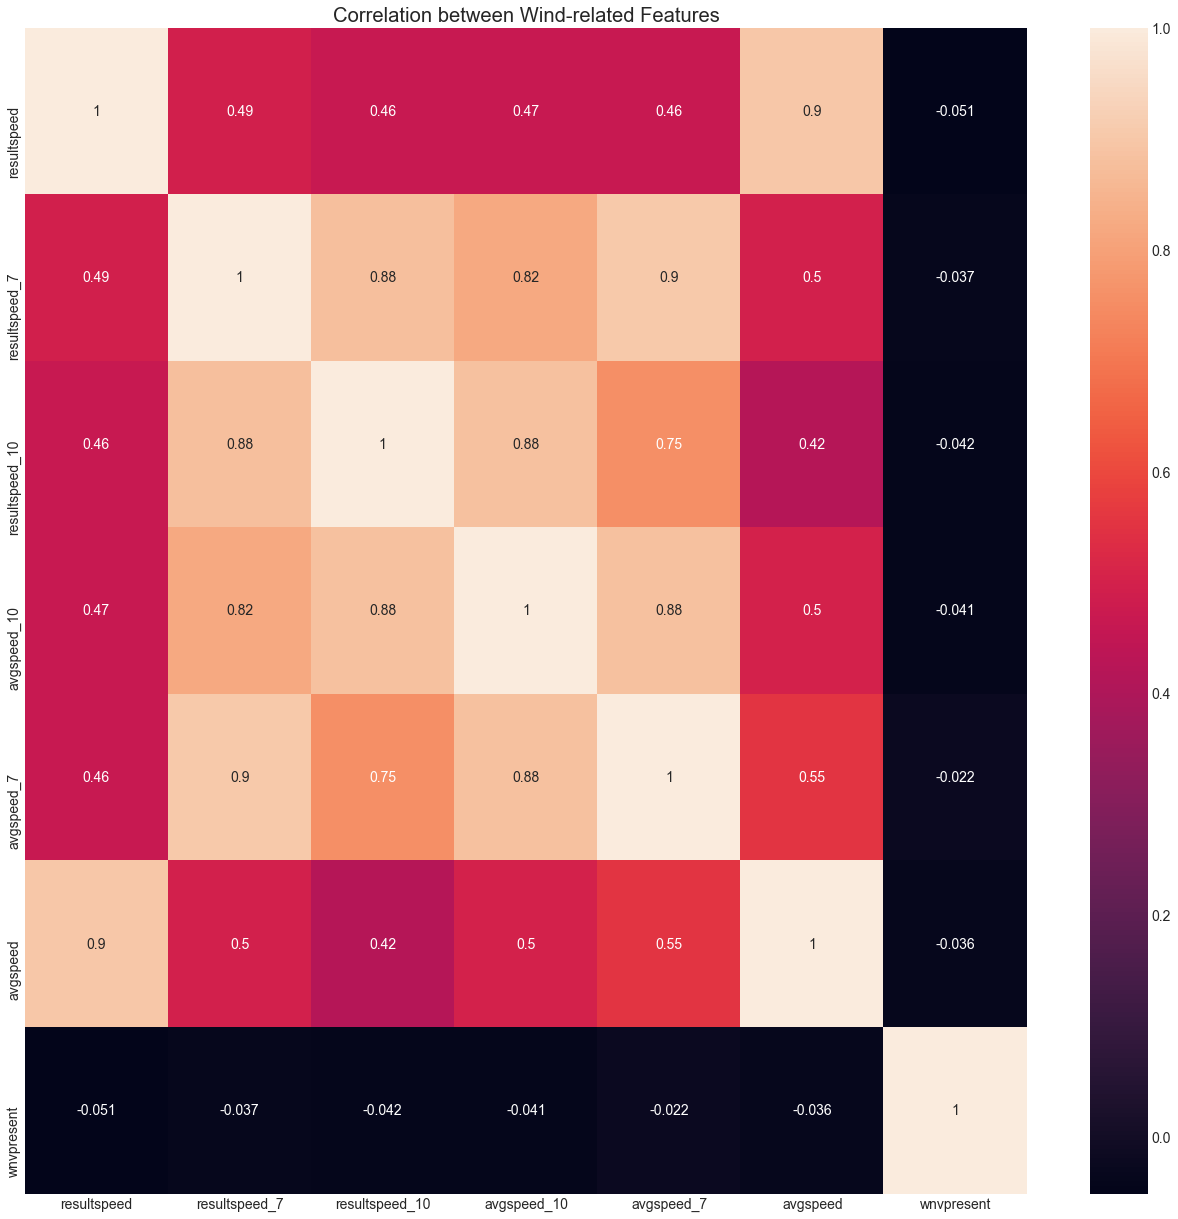

In [405]:
wind_features = ['resultspeed', 'resultspeed_7', 'resultspeed_10', 'avgspeed_10', 'avgspeed_7', 'avgspeed', 'wnvpresent']
plt.figure(figsize = (20,20))
sns.heatmap(merged_train[wind_features].corr(), annot = True)
plt.title("Correlation between Wind-related Features");

`Resultspeed` has the strongest correlation to `wnvpresent` compared to the rest of the features. It has very high correlation with `avgspeed` so we will drop `avgspeed`. `avgspeed_7` has strong correlation with `avgspeed_10`, and `avgspeed_10` has a stronger correlation with `wnvpresent` so we will keep `avgspeed_10`. `resultspeed_7` and `resultspeed_10` also has pretty strong correlation. We will drop both. 

In [406]:
merged_train.drop(columns = ['avgspeed', 'avgspeed_7','resultspeed_10', 'resultspeed_7'], inplace = True)
merged_test.drop(columns = ['avgspeed', 'avgspeed_7','resultspeed_10', 'resultspeed_7'], inplace = True)
# view
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed_10,cool_7,darkhours,darkhours_10,darkhours_7,date,dewpoint_10,heat_10,latitude,longitude,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,8.29,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,41.954690,-87.800991,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
1,8.29,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,41.954690,-87.800991,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
2,8.29,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,41.994991,-87.769279,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
3,8.29,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,41.974089,-87.824812,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923
4,8.29,1.714286,9.04,9.069,9.057143,2007-05-29,50.3,1.8,41.974089,-87.824812,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923


Shape of train set:  (8475, 35)


,avgspeed_10,cool_7,darkhours,darkhours_10,darkhours_7,date,dewpoint_10,heat_10,id,latitude,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,11.53,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,1,41.95469,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
1,11.53,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,2,41.95469,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
2,11.53,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,3,41.95469,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
3,11.53,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,4,41.95469,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
4,11.53,7.0,8.9,8.916,8.908571,2008-06-11,64.4,0.0,5,41.95469,...,0,1,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556


Shape of test set:  (116293, 35)


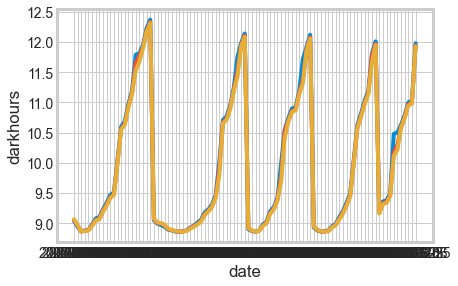

In [407]:
#lineplot for heat and cool
sns.lineplot(data = merged_train, y ='darkhours', x = 'date')
sns.lineplot(data = merged_train, y ='darkhours_7', x = 'date')
sns.lineplot(data = merged_train, y ='darkhours_10', x = 'date');

Darkhours and rolling mean are very strongly correlated with each other so we will keep only one. The one with the highest correlation to `wnvpresent`. 

In [408]:
# explore correlation of each of dark hours with target vriable
darkhour = merged_train[['darkhours', 'darkhours_7', 'darkhours_10', 'wnvpresent']]
darkhour.corr()['wnvpresent'].sort_values()

darkhours_10    0.075575
darkhours_7     0.075601
darkhours       0.075875
wnvpresent      1.000000
Name: wnvpresent, dtype: float64

In [409]:
merged_train.drop(columns = ['darkhours_7', 'darkhours_10'], inplace = True)
merged_test.drop(columns = ['darkhours_7', 'darkhours_10'], inplace = True)
# view
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed_10,cool_7,darkhours,date,dewpoint_10,heat_10,latitude,longitude,mth,nearest_stn,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.954690,-87.800991,5,1.0,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
1,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.954690,-87.800991,5,1.0,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
2,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.994991,-87.769279,5,1.0,...,0,0,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556
3,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.974089,-87.824812,5,1.0,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923
4,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.974089,-87.824812,5,1.0,...,0,0,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923


Shape of train set:  (8475, 33)


,avgspeed_10,cool_7,darkhours,date,dewpoint_10,heat_10,id,latitude,longitude,mth,...,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps
0,11.53,7.0,8.9,2008-06-11,64.4,0.0,1,41.95469,-87.800991,6,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
1,11.53,7.0,8.9,2008-06-11,64.4,0.0,2,41.95469,-87.800991,6,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
2,11.53,7.0,8.9,2008-06-11,64.4,0.0,3,41.95469,-87.800991,6,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
3,11.53,7.0,8.9,2008-06-11,64.4,0.0,4,41.95469,-87.800991,6,...,0,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556
4,11.53,7.0,8.9,2008-06-11,64.4,0.0,5,41.95469,-87.800991,6,...,0,1,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556


Shape of test set:  (116293, 33)


In [410]:
# explore correlation with the target vriable
merged_train.corr()['wnvpresent'].sort_values()

species_CULEX RESTUANS           -0.094047
longitude                        -0.076732
station                          -0.066947
nearest_stn                      -0.066947
heat_10                          -0.066818
close_to_27                      -0.062154
close_to_top_traps               -0.055389
close_to_37                      -0.054410
resultspeed                      -0.051165
avgspeed_10                      -0.041436
species_CULEX TERRITANS          -0.038609
close_to_18                      -0.036048
close_to_36                      -0.027465
species_CULEX SALINARIUS         -0.023743
species_CULEX TARSALIS           -0.006355
species_CULEX ERRATICUS          -0.002593
species_CULEX PIPIENS/RESTUANS    0.019620
grid_no                           0.024391
latitude                          0.030862
preciptotal_10                    0.033842
year                              0.043038
close_to_45                       0.047044
darkhours                         0.075875
cool_7     

### Group species
For species that are not carriers of WNV, we will group them together. 

In [411]:
merged_train['species_non_carriers'] = merged_train['species_CULEX TERRITANS']+merged_train['species_CULEX SALINARIUS']+merged_train['species_CULEX TARSALIS']+merged_train['species_CULEX ERRATICUS']
merged_test['species_non_carriers'] = merged_test['species_CULEX TERRITANS']+merged_test['species_CULEX SALINARIUS']+merged_train['species_CULEX TARSALIS']+merged_test['species_CULEX ERRATICUS']
merged_test['species_non_carriers'].fillna(0, inplace = True)
# drop
merged_train.drop(columns = ['species_CULEX TERRITANS','species_CULEX SALINARIUS','species_CULEX TARSALIS','species_CULEX ERRATICUS','species_UNSPECIFIED CULEX'], inplace = True)
merged_test.drop(columns = ['species_CULEX TERRITANS','species_CULEX SALINARIUS','species_CULEX TARSALIS','species_CULEX ERRATICUS','species_UNSPECIFIED CULEX'], inplace = True)

In [412]:
# view
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed_10,cool_7,darkhours,date,dewpoint_10,heat_10,latitude,longitude,mth,nearest_stn,...,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps,species_non_carriers
0,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.954690,-87.800991,5,1.0,...,1,0,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556,0
1,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.954690,-87.800991,5,1.0,...,0,1,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556,0
2,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.994991,-87.769279,5,1.0,...,0,1,45.0,1.0,0.5,0.055556,0.125000,0.2,1.880556,0
3,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.974089,-87.824812,5,1.0,...,1,0,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923,0
4,8.29,1.714286,9.04,2007-05-29,50.3,1.8,41.974089,-87.824812,5,1.0,...,0,1,44.0,1.0,0.2,0.040000,0.076923,0.1,1.416923,0


Shape of train set:  (8475, 29)


,avgspeed_10,cool_7,darkhours,date,dewpoint_10,heat_10,id,latitude,longitude,mth,...,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,grid_no,close_to_45,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps,species_non_carriers
0,11.53,7.0,8.9,2008-06-11,64.4,0.0,1,41.95469,-87.800991,6,...,1,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556,0.0
1,11.53,7.0,8.9,2008-06-11,64.4,0.0,2,41.95469,-87.800991,6,...,0,1,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556,0.0
2,11.53,7.0,8.9,2008-06-11,64.4,0.0,3,41.95469,-87.800991,6,...,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556,0.0
3,11.53,7.0,8.9,2008-06-11,64.4,0.0,4,41.95469,-87.800991,6,...,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556,1.0
4,11.53,7.0,8.9,2008-06-11,64.4,0.0,5,41.95469,-87.800991,6,...,0,0,45.0,1.0,0.5,0.055556,0.125,0.2,1.880556,1.0


Shape of test set:  (116293, 29)


### Correlation between distance-related variables
Find any collinearity between distance-related variables, since we have feature engineered some new variables. 

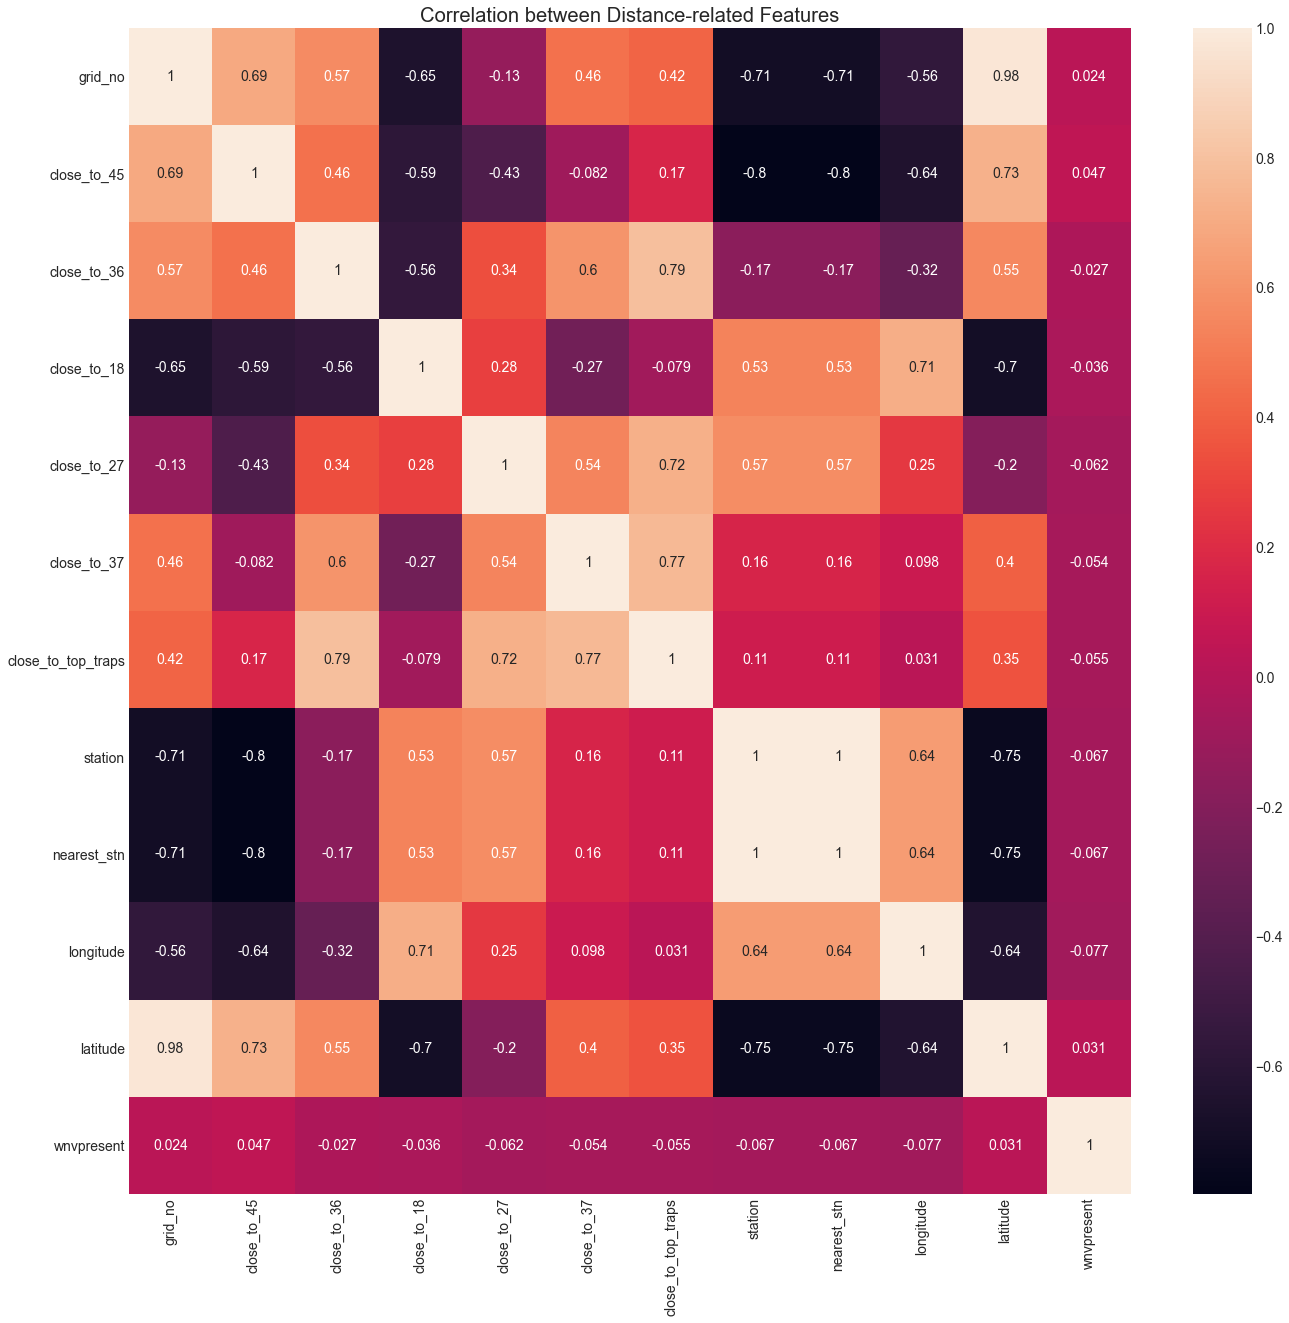

In [413]:
dist_features = ['grid_no', 'close_to_45', 'close_to_36', 'close_to_18', 'close_to_27', 'close_to_37', 'close_to_top_traps', 'station', 'nearest_stn', 'longitude', 'latitude', 'wnvpresent']
plt.figure(figsize = (20,20))
sns.heatmap(merged_train[dist_features].corr(), annot = True)
plt.title("Correlation between Distance-related Features");

Drop features that are highly collinear with more than one feature, ie. `grid_no`, `close_to_45` and `latitiude`.

In [414]:
# drop
merged_train.drop(columns = ['grid_no','close_to_45','latitude'], inplace = True)
merged_test.drop(columns = ['grid_no','close_to_45','latitude'], inplace = True)

In [415]:
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed_10,cool_7,darkhours,date,dewpoint_10,heat_10,longitude,mth,nearest_stn,nummosquitos,...,year,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps,species_non_carriers
0,8.29,1.714286,9.04,2007-05-29,50.3,1.8,-87.800991,5,1.0,1,...,2007,0,1,0,0.5,0.055556,0.125000,0.2,1.880556,0
1,8.29,1.714286,9.04,2007-05-29,50.3,1.8,-87.800991,5,1.0,1,...,2007,0,0,1,0.5,0.055556,0.125000,0.2,1.880556,0
2,8.29,1.714286,9.04,2007-05-29,50.3,1.8,-87.769279,5,1.0,1,...,2007,0,0,1,0.5,0.055556,0.125000,0.2,1.880556,0
3,8.29,1.714286,9.04,2007-05-29,50.3,1.8,-87.824812,5,1.0,1,...,2007,0,1,0,0.2,0.040000,0.076923,0.1,1.416923,0
4,8.29,1.714286,9.04,2007-05-29,50.3,1.8,-87.824812,5,1.0,4,...,2007,0,0,1,0.2,0.040000,0.076923,0.1,1.416923,0


Shape of train set:  (8475, 26)


,avgspeed_10,cool_7,darkhours,date,dewpoint_10,heat_10,id,longitude,mth,nearest_stn,...,year,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps,species_non_carriers
0,11.53,7.0,8.9,2008-06-11,64.4,0.0,1,-87.800991,6,1.0,...,2008,0,1,0,0.5,0.055556,0.125,0.2,1.880556,0.0
1,11.53,7.0,8.9,2008-06-11,64.4,0.0,2,-87.800991,6,1.0,...,2008,0,0,1,0.5,0.055556,0.125,0.2,1.880556,0.0
2,11.53,7.0,8.9,2008-06-11,64.4,0.0,3,-87.800991,6,1.0,...,2008,1,0,0,0.5,0.055556,0.125,0.2,1.880556,0.0
3,11.53,7.0,8.9,2008-06-11,64.4,0.0,4,-87.800991,6,1.0,...,2008,0,0,0,0.5,0.055556,0.125,0.2,1.880556,1.0
4,11.53,7.0,8.9,2008-06-11,64.4,0.0,5,-87.800991,6,1.0,...,2008,0,0,0,0.5,0.055556,0.125,0.2,1.880556,1.0


Shape of test set:  (116293, 26)


### Drop dates 

In [416]:
merged_train.drop(columns = ['date'], inplace = True)
merged_test.drop(columns = ['date'], inplace = True)

### View final processed data

In [417]:
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed_10,cool_7,darkhours,dewpoint_10,heat_10,longitude,mth,nearest_stn,nummosquitos,preciptotal_10,...,year,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps,species_non_carriers
0,8.29,1.714286,9.04,50.3,1.8,-87.800991,5,1.0,1,0.15,...,2007,0,1,0,0.5,0.055556,0.125000,0.2,1.880556,0
1,8.29,1.714286,9.04,50.3,1.8,-87.800991,5,1.0,1,0.15,...,2007,0,0,1,0.5,0.055556,0.125000,0.2,1.880556,0
2,8.29,1.714286,9.04,50.3,1.8,-87.769279,5,1.0,1,0.15,...,2007,0,0,1,0.5,0.055556,0.125000,0.2,1.880556,0
3,8.29,1.714286,9.04,50.3,1.8,-87.824812,5,1.0,1,0.15,...,2007,0,1,0,0.2,0.040000,0.076923,0.1,1.416923,0
4,8.29,1.714286,9.04,50.3,1.8,-87.824812,5,1.0,4,0.15,...,2007,0,0,1,0.2,0.040000,0.076923,0.1,1.416923,0


Shape of train set:  (8475, 25)


,avgspeed_10,cool_7,darkhours,dewpoint_10,heat_10,id,longitude,mth,nearest_stn,nummosquitos,...,year,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps,species_non_carriers
0,11.53,7.0,8.9,64.4,0.0,1,-87.800991,6,1.0,14.0,...,2008,0,1,0,0.5,0.055556,0.125,0.2,1.880556,0.0
1,11.53,7.0,8.9,64.4,0.0,2,-87.800991,6,1.0,14.0,...,2008,0,0,1,0.5,0.055556,0.125,0.2,1.880556,0.0
2,11.53,7.0,8.9,64.4,0.0,3,-87.800991,6,1.0,14.0,...,2008,1,0,0,0.5,0.055556,0.125,0.2,1.880556,0.0
3,11.53,7.0,8.9,64.4,0.0,4,-87.800991,6,1.0,14.0,...,2008,0,0,0,0.5,0.055556,0.125,0.2,1.880556,1.0
4,11.53,7.0,8.9,64.4,0.0,5,-87.800991,6,1.0,14.0,...,2008,0,0,0,0.5,0.055556,0.125,0.2,1.880556,1.0


Shape of test set:  (116293, 25)


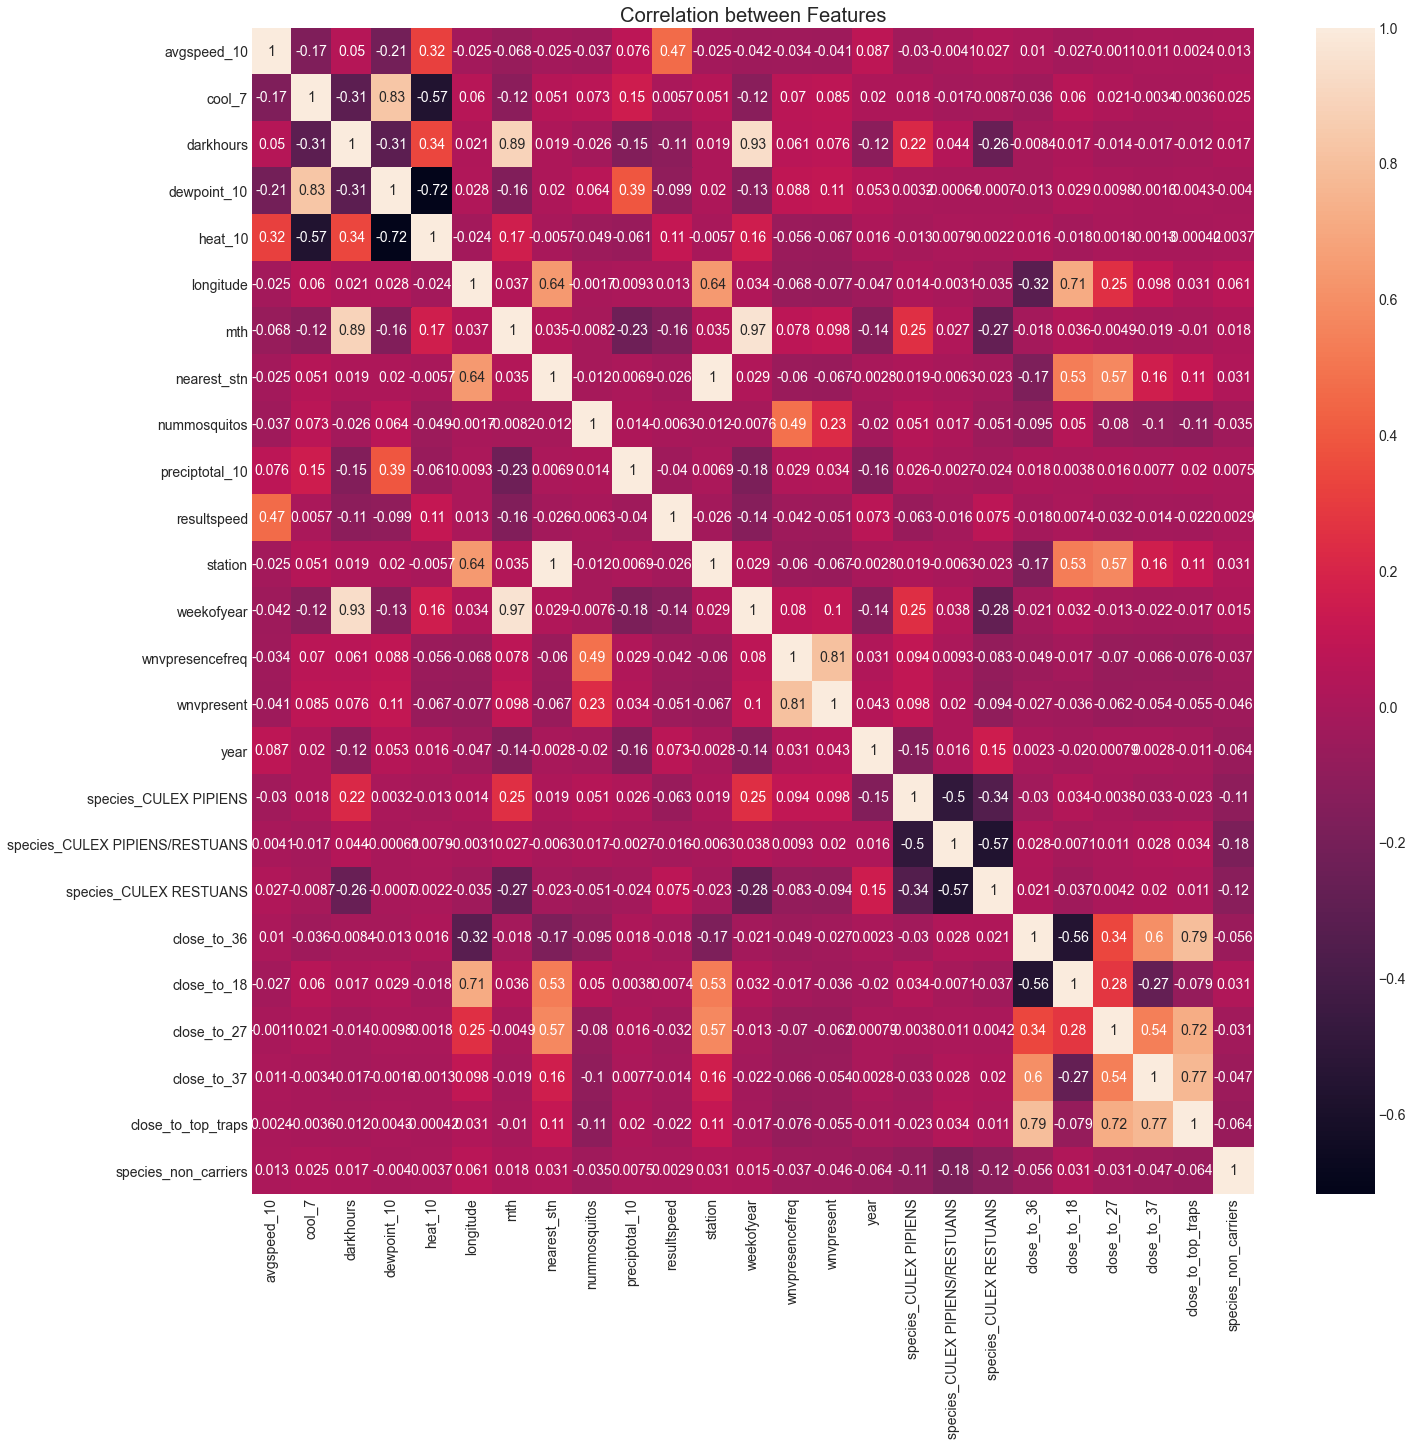

In [418]:
#view correlation with features
plt.figure(figsize = (20,20))
sns.heatmap(merged_train.corr(), annot = True)
plt.title("Correlation between Features");

| Features with very strong correlation (>0.8) with each other | Treatment |
|:-----: | :---------- |
| mth, darkhours, weekof year | weekofyear has the highest correlation with wnvpresent so we will keep this and drop the rest |

In [419]:
merged_train.drop(columns = ['mth', 'darkhours'], inplace = True)
merged_test.drop(columns = ['mth', 'darkhours'], inplace = True)

In [420]:
# view
display(merged_train.head())
print("Shape of train set: ", merged_train.shape)
display(merged_test.head())
print("Shape of test set: ", merged_test.shape)

,avgspeed_10,cool_7,dewpoint_10,heat_10,longitude,nearest_stn,nummosquitos,preciptotal_10,resultspeed,station,...,year,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps,species_non_carriers
0,8.29,1.714286,50.3,1.8,-87.800991,1.0,1,0.15,5.8,1,...,2007,0,1,0,0.5,0.055556,0.125000,0.2,1.880556,0
1,8.29,1.714286,50.3,1.8,-87.800991,1.0,1,0.15,5.8,1,...,2007,0,0,1,0.5,0.055556,0.125000,0.2,1.880556,0
2,8.29,1.714286,50.3,1.8,-87.769279,1.0,1,0.15,5.8,1,...,2007,0,0,1,0.5,0.055556,0.125000,0.2,1.880556,0
3,8.29,1.714286,50.3,1.8,-87.824812,1.0,1,0.15,5.8,1,...,2007,0,1,0,0.2,0.040000,0.076923,0.1,1.416923,0
4,8.29,1.714286,50.3,1.8,-87.824812,1.0,4,0.15,5.8,1,...,2007,0,0,1,0.2,0.040000,0.076923,0.1,1.416923,0


Shape of train set:  (8475, 23)


,avgspeed_10,cool_7,dewpoint_10,heat_10,id,longitude,nearest_stn,nummosquitos,preciptotal_10,resultspeed,...,year,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,close_to_36,close_to_18,close_to_27,close_to_37,close_to_top_traps,species_non_carriers
0,11.53,7.0,64.4,0.0,1,-87.800991,1.0,14.0,0.312,8.9,...,2008,0,1,0,0.5,0.055556,0.125,0.2,1.880556,0.0
1,11.53,7.0,64.4,0.0,2,-87.800991,1.0,14.0,0.312,8.9,...,2008,0,0,1,0.5,0.055556,0.125,0.2,1.880556,0.0
2,11.53,7.0,64.4,0.0,3,-87.800991,1.0,14.0,0.312,8.9,...,2008,1,0,0,0.5,0.055556,0.125,0.2,1.880556,0.0
3,11.53,7.0,64.4,0.0,4,-87.800991,1.0,14.0,0.312,8.9,...,2008,0,0,0,0.5,0.055556,0.125,0.2,1.880556,1.0
4,11.53,7.0,64.4,0.0,5,-87.800991,1.0,14.0,0.312,8.9,...,2008,0,0,0,0.5,0.055556,0.125,0.2,1.880556,1.0


Shape of test set:  (116293, 23)


### Feature Selection 
Use chi2 to select top 7 features.

In [421]:
# use chi2 to select best 10 features
X = merged_train.drop(columns = ['wnvpresent'])
y = merged_train['wnvpresent']

best_features = SelectKBest(score_func = chi2, k = 7)
X = X.abs()
fit = best_features.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat for viz
featurescores = pd.concat([dfcolumns, dfscores], axis = 1)
featurescores.columns = ['Features', 'Score']
print(featurescores.nlargest(7,'Score'))

                  Features          Score
6             nummosquitos  163518.159194
1                   cool_7     189.143885
3                  heat_10     153.150629
13   species_CULEX PIPIENS      62.497274
10              weekofyear      60.088232
2              dewpoint_10      58.933046
15  species_CULEX RESTUANS      53.794378


Use these for modelling.

In [422]:
model_train = merged_train[['nummosquitos', 'cool_7', 'heat_10', 'species_CULEX PIPIENS', 'weekofyear', 'dewpoint_10', 'species_CULEX RESTUANS', 'wnvpresent' ]]
model_test = merged_test[['nummosquitos', 'cool_7', 'heat_10', 'species_CULEX PIPIENS', 'weekofyear', 'dewpoint_10', 'species_CULEX RESTUANS', 'id' ]]

### Save processed train and test sets

In [423]:
model_train.to_csv("../data/clean/train_processed.csv", index = False)
model_test.to_csv("../data/clean/test_processed.csv", index = False)

Data is now ready for modelling! Refer to this [notebook](04-modelling-and-tuning.ipynb) for modelling.